In [389]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from fasteda import fast_eda
import warnings
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from sklearn.linear_model import LinearRegression
import xgboost as xg
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

### Table of Contents

[Exploratory analysis](#exploratory-analysis)

[Preprocessing and Forecasting](#preprocessing-and-forecasting)

### Exploratory analysis

In [6]:
data = pd.read_csv('data/walmart-sales-dataset-of-45stores.csv', delimiter=',')
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


Missing values:


,0


----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(6435, 8)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB
----------------------------------------------------------------------------------------------------
Describe DataFrame:



,count,mean,median,std,min,25%,50%,75%,max,skewness,kurtosis
Store,6435,23,23,12.988,1,12,23,34,45,0.000000,-1.201186
Weekly_Sales,6435,1046964.878,960746.04,564366.622,209986.25,553350.105,960746.04,1420158.66,3818686.45,0.668206,0.052167
Holiday_Flag,6435,0.07,0,0.255,0,0,0,0,1,3.372712,9.375188
Temperature,6435,60.664,62.67,18.445,-2.06,47.46,62.67,74.94,100.14,-0.336689,-0.613257
Fuel_Price,6435,3.359,3.445,0.459,2.472,2.933,3.445,3.735,4.468,-0.096136,-1.177395
CPI,6435,171.578,182.617,39.357,126.064,131.735,182.617,212.743,227.233,0.063477,-1.839316
Unemployment,6435,7.999,7.874,1.876,3.879,6.891,7.874,8.622,14.313,1.187867,2.636729


----------------------------------------------------------------------------------------------------
DataFrame Correlation:



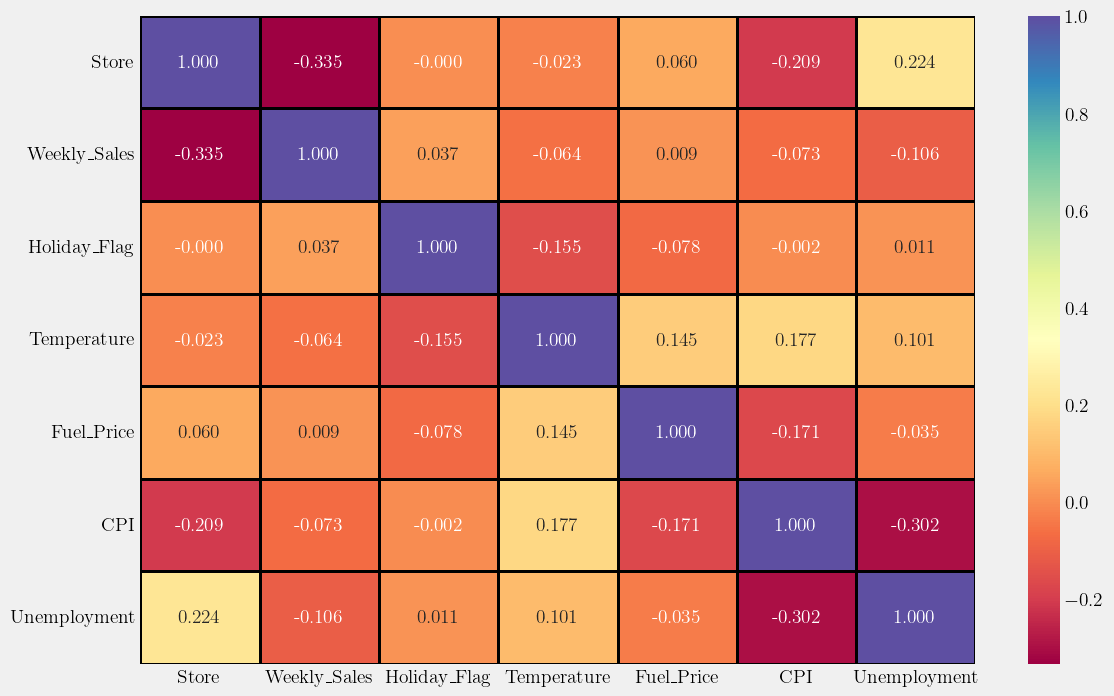

In [7]:
fast_eda(data, countplot=False, pairplot=False, hist_box_plot=False)

In [8]:
data['Date'] = pd.to_datetime(data['Date'])

In [9]:
x_date = data['Date'].dt.strftime('%m/%Y')
x_date.shape

(6435,)

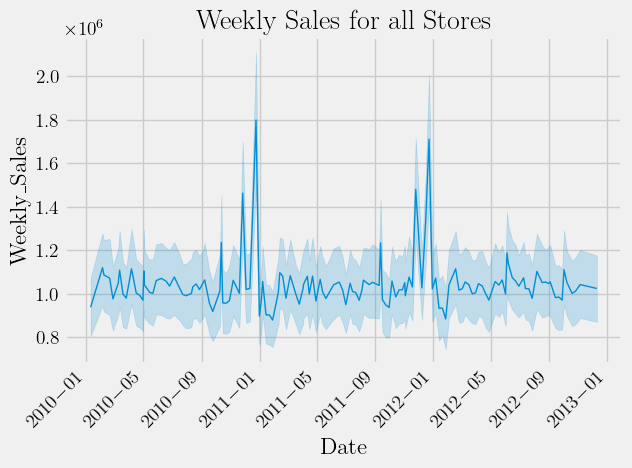

In [10]:
fig = plt.figure()
ax = sn.lineplot(data, x='Date',  y='Weekly_Sales', lw=1)
fig.autofmt_xdate(rotation=45)
plt.title('Weekly Sales for all Stores')
plt.show()

In [11]:
# total number of weeks
weeks = []
for i in range(1,46):
    weeks = weeks + list(range(1,144))
weeks = np.transpose(weeks)

In [13]:
data['Week'] = weeks

In [14]:
data.groupby('Store').get_group(1).head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Week
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106,1
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106,2
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,3
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,4
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106,5


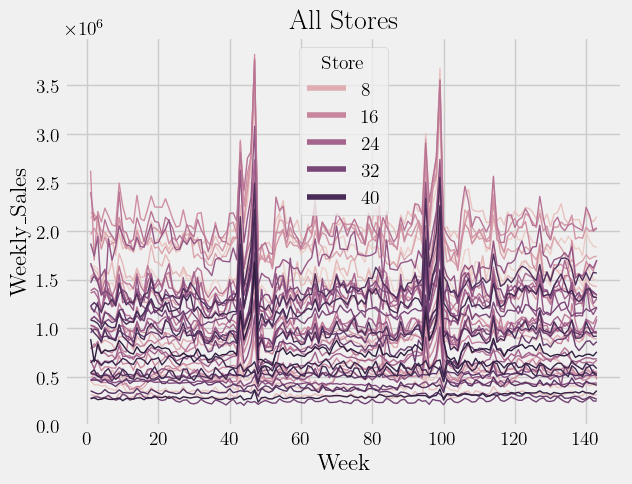

In [15]:
sn.lineplot(data=data, x='Week', y='Weekly_Sales', hue='Store', lw=1)
plt.title('All Stores')
plt.ylim(0,)
plt.show()

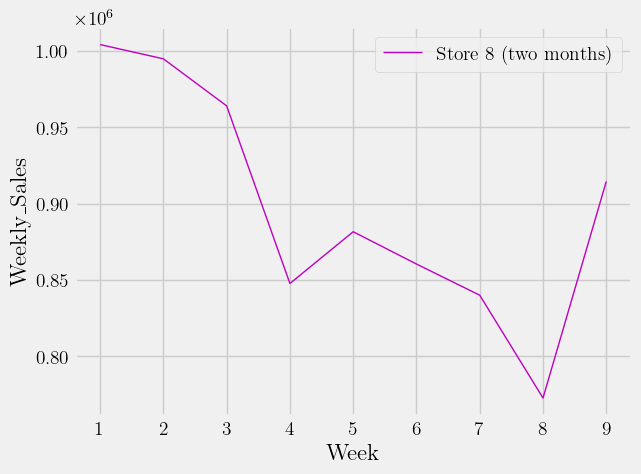

In [16]:
ax = sn.lineplot(data=data[data['Store'] == 8][:9], x='Week', y='Weekly_Sales', lw=1, color='m', label='Store 8 (two months)')
plt.show()

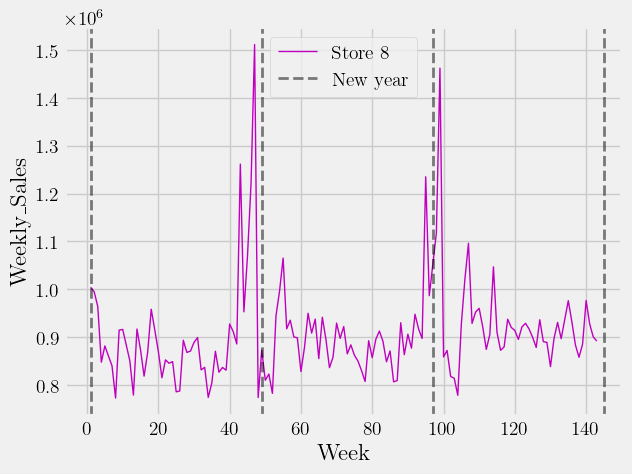

In [17]:
ax = sn.lineplot(data=data[data['Store'] == 8], x='Week', y='Weekly_Sales', lw=1, color='m', label='Store 8')
ax.axvline(x=1, linestyle='--', alpha=0.5, color='k', lw=2, label='New year')
ax.axvline(x=49, linestyle='--', alpha=0.5, color='k', lw=2)
ax.axvline(x=48*2+1, linestyle='--', alpha=0.5, color='k', lw=2)
ax.axvline(x=48*3+1, linestyle='--', alpha=0.5, color='k', lw=2)
plt.legend()
plt.show()

In [18]:
store_8 = data[data['Store'] == 8][['Date','Weekly_Sales']].set_index('Date')
store_8.head()

,Weekly_Sales
Date,
2010-05-02,1004137.09
2010-12-02,994801.40
2010-02-19,963960.37
2010-02-26,847592.11
2010-05-03,881503.95


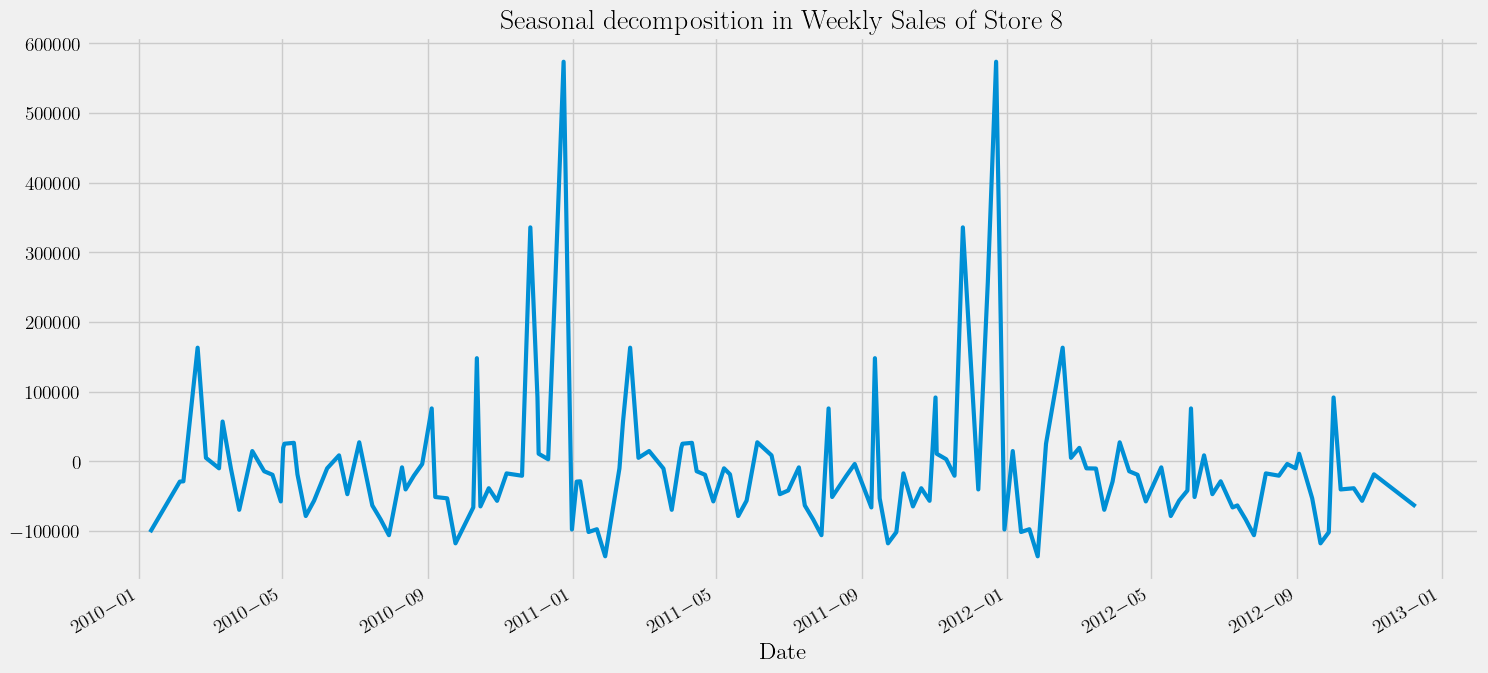

In [19]:
week_period = 52
decomposition = sm.tsa.seasonal_decompose(x=store_8['Weekly_Sales'], period=week_period)

plt.figure(figsize=(16,8))
decomposition.seasonal.plot(lw=3)
plt.title('Seasonal decomposition in Weekly Sales of Store 8')
plt.show()

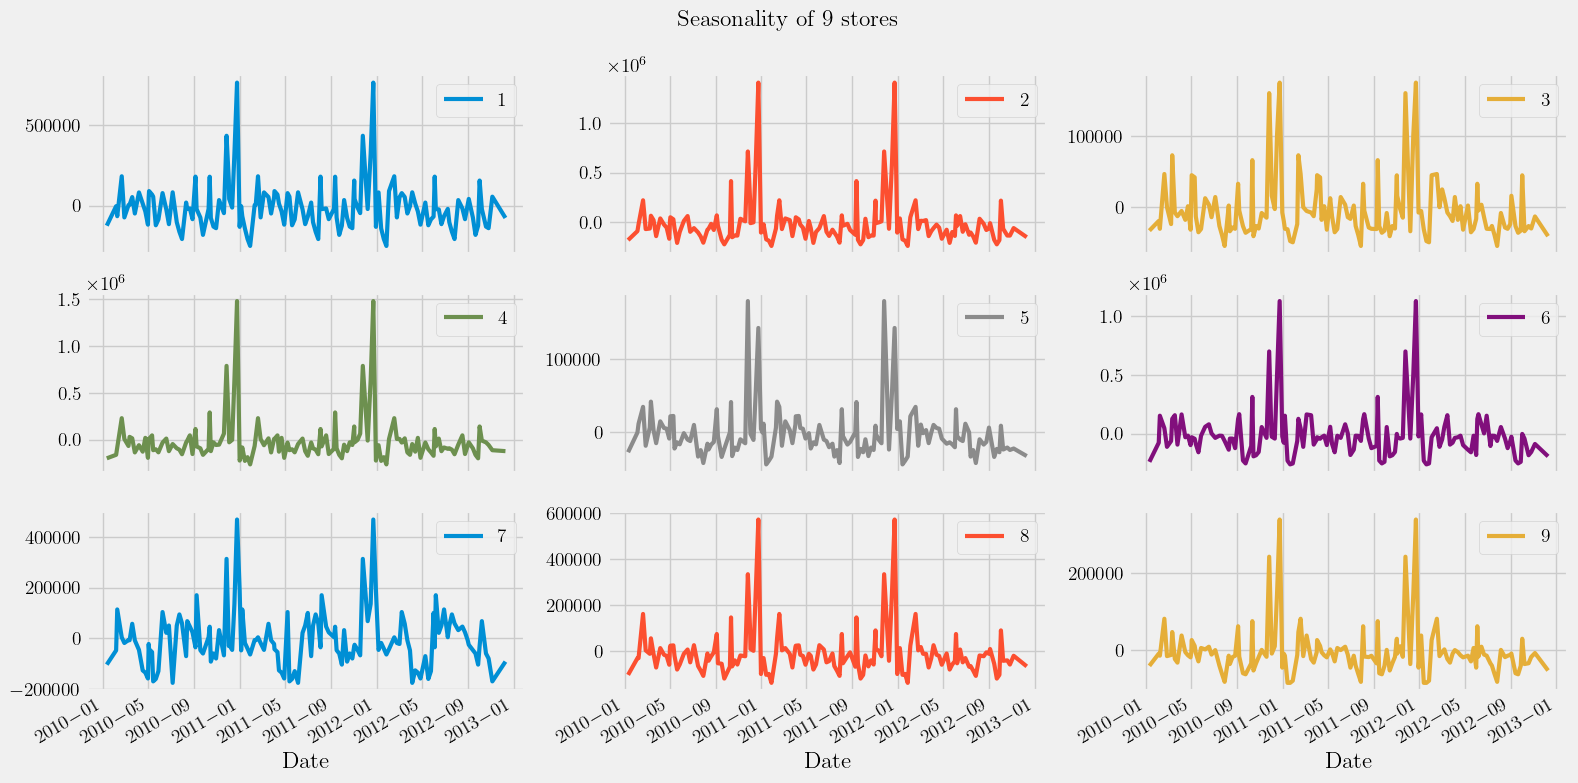

In [20]:
seasonality_dict = {}

for i in range(1,10):
    store_i = data[data['Store'] == i][['Date','Weekly_Sales']].set_index('Date')
    seasonality_dict[i] = sm.tsa.seasonal_decompose(store_i, period=week_period).seasonal

pd.DataFrame(seasonality_dict).plot(subplots=True, layout=(3,3), lw=3, figsize=(16,8), title='Seasonality of 9 stores')
plt.tight_layout()
plt.show()

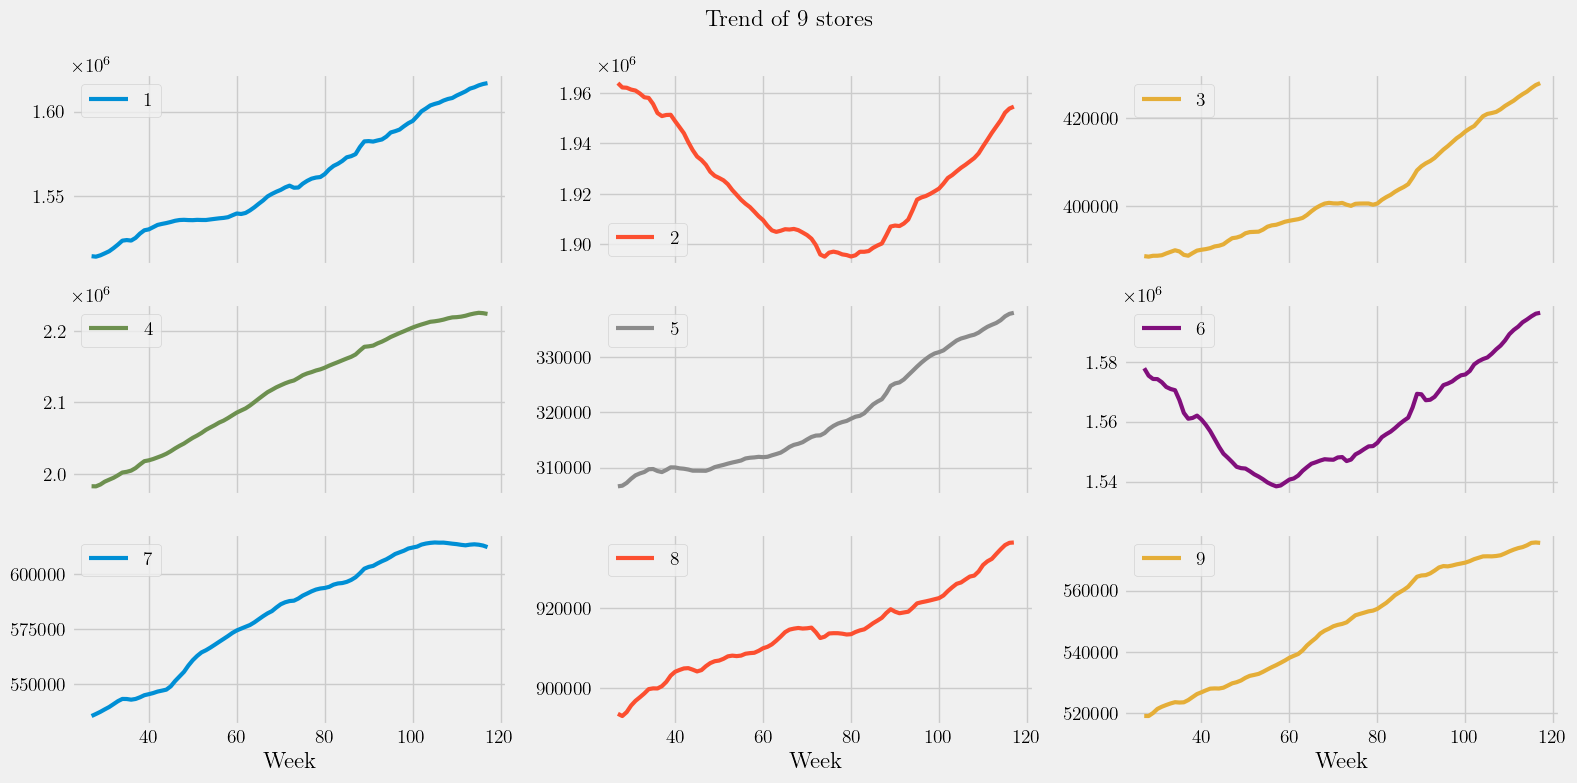

In [21]:
trend_dict = {}

for i in range(1,10):
    store_i = data[data['Store'] == i][['Week','Weekly_Sales']].set_index('Week')
    trend_dict[i] = sm.tsa.seasonal_decompose(store_i, period=week_period).trend

pd.DataFrame(trend_dict).dropna().plot(subplots=True, layout=(3,3), lw=3, figsize=(16,8), title='Trend of 9 stores')
plt.tight_layout()
plt.show()

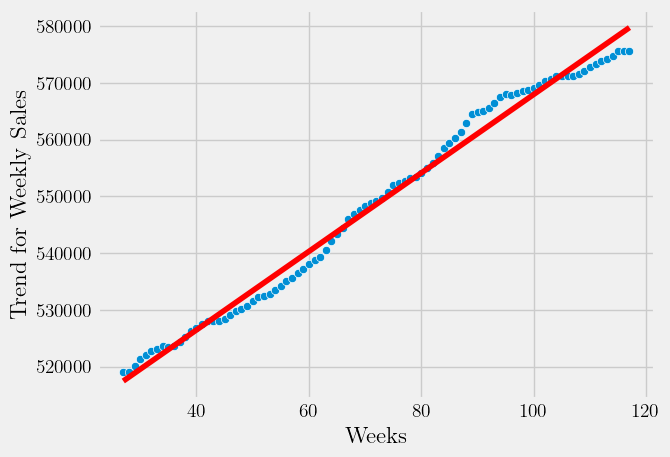

In [74]:
store = 9

weeks = np.array(trend_dict[store].dropna().index)

linear = LinearRegression()

X = weeks.reshape(-1,1)
y = trend_dict[store].dropna()
linear.fit(X, y)

sn.scatterplot(x=X.ravel(), y=y, lw=3)
sn.lineplot(x=X.ravel(), y=linear.coef_[0] * X.ravel() + linear.intercept_, color='r')

plt.xlabel('Weeks')
plt.ylabel('Trend for Weekly Sales')
# plt.ylim(850e3,1000e3)
plt.show()

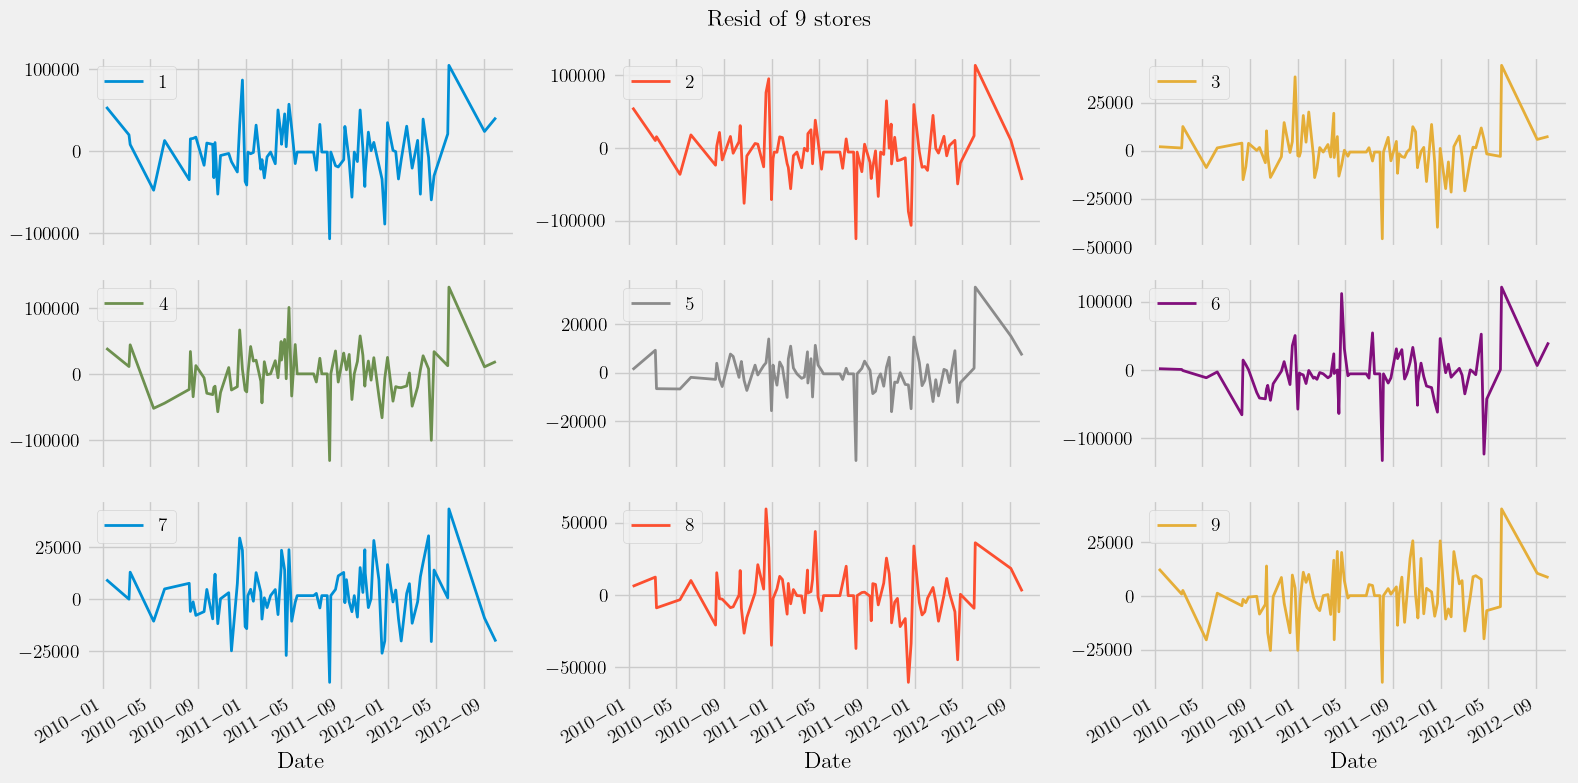

In [89]:
resid_dict = {}

for i in range(1,10):
    store_i = data[data['Store'] == i][['Date','Weekly_Sales']].set_index('Date')
    resid_dict[i] = sm.tsa.seasonal_decompose(store_i, period=week_period).resid

resid = pd.DataFrame(resid_dict).dropna()
resid.dropna().plot(subplots=True, layout=(3,3), lw=2, figsize=(16,8), title='Resid of 9 stores')
plt.tight_layout()
plt.show()

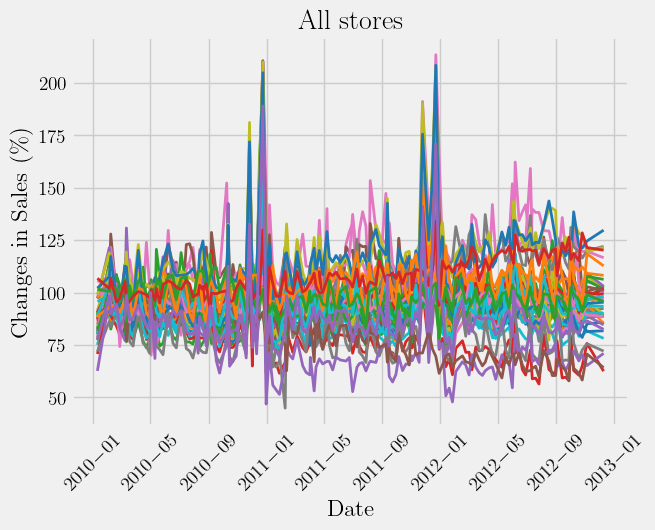

In [ ]:
stores = {}
n = 45
colors = sn.color_palette('tab10', n_colors=n)

for i in range(1,n+1):
    week_sales_i = data[data['Store'] == i][['Date','Weekly_Sales']].set_index('Date')
    store_i = week_sales_i.div(week_sales_i.iloc[0]).mul(100).sort_index()
    ax = sn.lineplot(store_i, x=store_i.index, y='Weekly_Sales', lw=2, color=colors[i-1], label=i)
plt.legend().remove()
plt.xticks(rotation=45)
plt.title('All stores')
plt.ylabel('Changes in Sales (\%)')
plt.show()

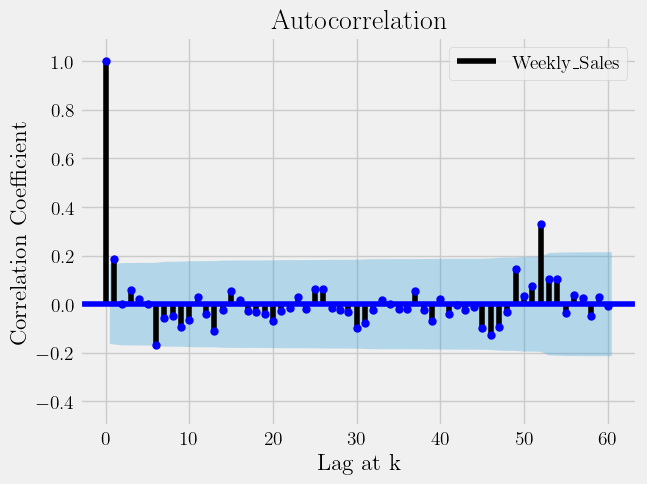

In [ ]:
stores_sales = data.groupby('Date').agg('sum')['Weekly_Sales']
fig = tsaplots.plot_acf(stores_sales, lags=60, color='b', vlines_kwargs={'color':'k'})
plt.ylim(-0.5,1.1)
plt.xlabel('Lag at k')
plt.ylabel('Correlation Coefficient')
plt.legend(['Weekly_Sales'])
plt.show()

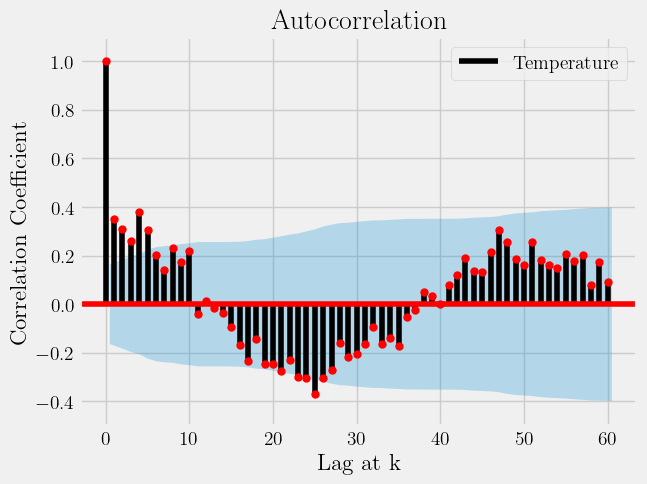

In [ ]:
stores_sales = data.groupby('Date').agg('mean')['Temperature']
fig = tsaplots.plot_acf(stores_sales, lags=60, color='r', vlines_kwargs={'color':'k'})
plt.ylim(-0.5,1.1)
plt.xlabel('Lag at k')
plt.ylabel('Correlation Coefficient')
plt.legend(['Temperature'])
plt.show()

##### Predicting the total sales (all stores) with a ML model

In [205]:
data_all = data.groupby('Week').agg('sum')['Weekly_Sales']
data_all = pd.DataFrame(data_all)
data_all['Date'] = data['Date']

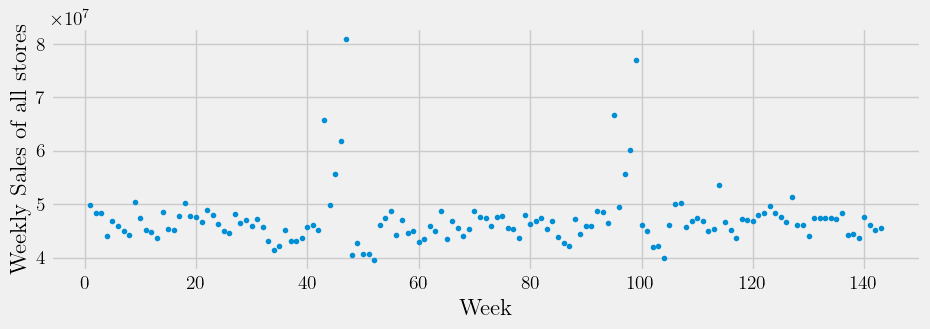

In [207]:
data_all['Weekly_Sales'].plot(style='.', figsize=(10,3))
plt.ylabel('Weekly Sales of all stores');

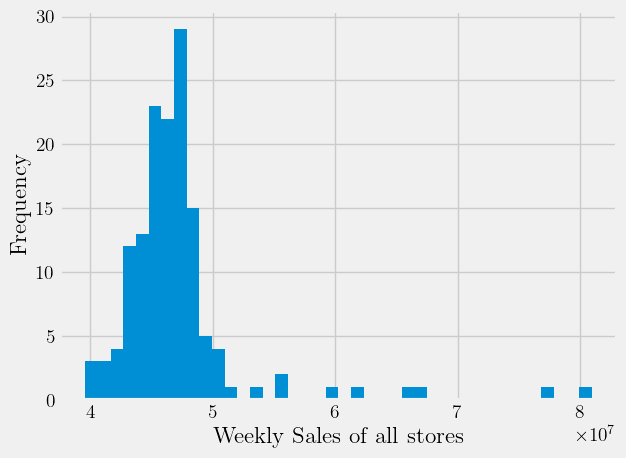

In [208]:
data_all['Weekly_Sales'].plot(kind='hist', bins=40)
plt.xlabel('Weekly Sales of all stores');

### Preprocessing and Forecasting

In [209]:
tss = TimeSeriesSplit(n_splits=3, test_size=30)

In [210]:
X = data_all.index.to_numpy().reshape(-1,1)
y = data_all['Weekly_Sales'].to_numpy()

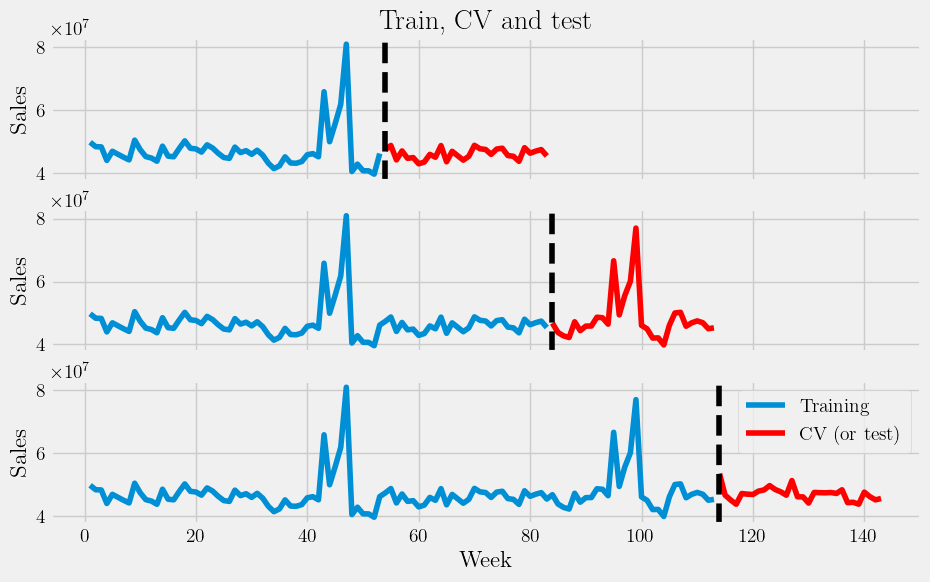

In [211]:
fig, ax = plt.subplots(3,1,figsize=(10,6), sharex=True)

i = 0
for train_i, cv_i in tss.split(data_all):
    data_all['Weekly_Sales'].iloc[train_i].plot(ax=ax[i], label='Training')
    data_all['Weekly_Sales'].iloc[cv_i].plot(ax=ax[i], label='CV (or test)', color='r')
    ax[i].set_ylabel('Sales')
    ax[i].axvline(x=data_all.iloc[cv_i].index[0], linestyle='--', c='k')
    i += 1
ax[0].set_title('Train, CV and test')
plt.legend()
plt.show()

In [255]:
def create_date(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Quarter'] = df['Date'].dt.quarter
    df['Week'] = df.index
    df['Week_cyclic'] = df['Date'].dt.week
    df['Day_of_Year'] = df['Date'].dt.dayofyear
    df['Day'] = df['Date'].dt.day
    df = df.drop(columns=['Date'])
    return df

In [259]:
df = create_date(data_all)

In [260]:
df.head()

,Weekly_Sales,Year,Month,Week_cyclic,Day,Day_of_Year,Quarter,Week
Week,,,,,,,,
1,49750740.50,2010,12,48,2,336,4,1
2,48336677.63,2010,2,7,19,50,1,2
3,48276993.78,2010,2,8,26,57,1,3
4,43968571.13,2010,5,18,3,123,2,4
5,46871470.30,2010,12,48,3,337,4,5


In [322]:
FEATURES = ['Year', 'Month', 'Week_cyclic', 'Day', 'Day_of_Year', 'Quarter', 'Week']
TARGET = 'Weekly_Sales'
scores = []

for train_i, cv_i in tss.split(df):
    train = df.iloc[train_i]
    cv = df.iloc[cv_i]

    X_train = train[FEATURES]
    X_cv = cv[FEATURES]

    y_train = train[TARGET]
    y_cv = cv[TARGET]

    xg_reg = xg.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=900, objective='reg:squarederror',
                             max_depth=2, learning_rate=0.05)

    xg_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_cv, y_cv)], verbose=0)
    y_pred = xg_reg.predict(X_cv)
    mse = mean_squared_error(y_cv, y_pred)
    rmse = np.sqrt(mse)
    scores.append(rmse)

print(scores)

[2826220.7948929803, 3597514.132526018, 2453565.6286529466]


In [337]:
train = []
cv = []

for train_i, cv_i in tss.split(df):
    train.append(df.iloc[train_i])
    cv.append(df.iloc[cv_i])

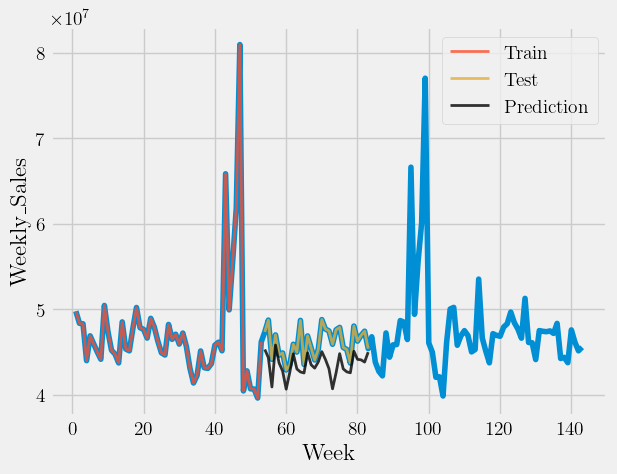

In [360]:
i = 0

FEATURES = ['Year', 'Month', 'Week_cyclic', 'Day', 'Day_of_Year', 'Quarter', 'Week']
TARGET = 'Weekly_Sales'

X_train = train[i][FEATURES]
X_cv = cv[i][FEATURES]

y_train = train[i][TARGET]
y_cv = cv[i][TARGET]

xg_reg = xg.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=500, objective='reg:squarederror',
                             max_depth=2, learning_rate=0.05)

xg_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_cv, y_cv)], verbose=0)
y_pred = xg_reg.predict(X_cv)

sn.lineplot(df['Weekly_Sales'])
sn.lineplot(y_train, lw=2, alpha=0.8, label='Train')
sn.lineplot(y_cv, lw=2, alpha=0.8, label='Test')
sn.lineplot(x=y_cv.index, y=y_pred, lw=2, alpha=0.8, color='k', label='Prediction')
plt.legend()
plt.show()

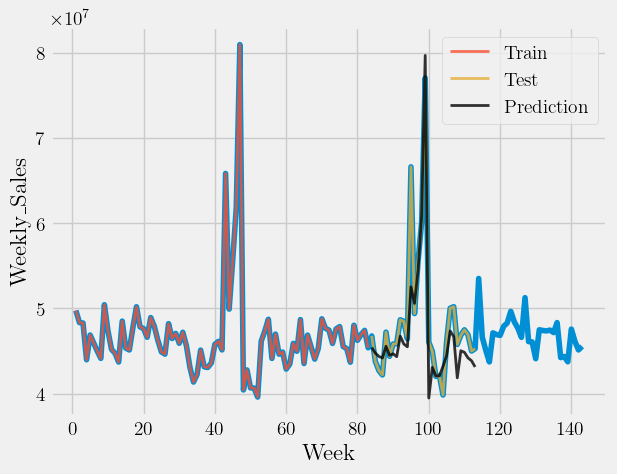

In [356]:
i = 1
X_train = train[i][FEATURES]
X_cv = cv[i][FEATURES]

y_train = train[i][TARGET]
y_cv = cv[i][TARGET]

xg_reg = xg.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=500, objective='reg:squarederror',
                             max_depth=2, learning_rate=0.05)

xg_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_cv, y_cv)], verbose=0)
y_pred = xg_reg.predict(X_cv)

sn.lineplot(df['Weekly_Sales'])
sn.lineplot(y_train, lw=2, alpha=0.8, label='Train')
sn.lineplot(y_cv, lw=2, alpha=0.8, label='Test')
sn.lineplot(x=y_cv.index, y=y_pred, lw=2, alpha=0.8, color='k', label='Prediction')
plt.legend()
plt.show()

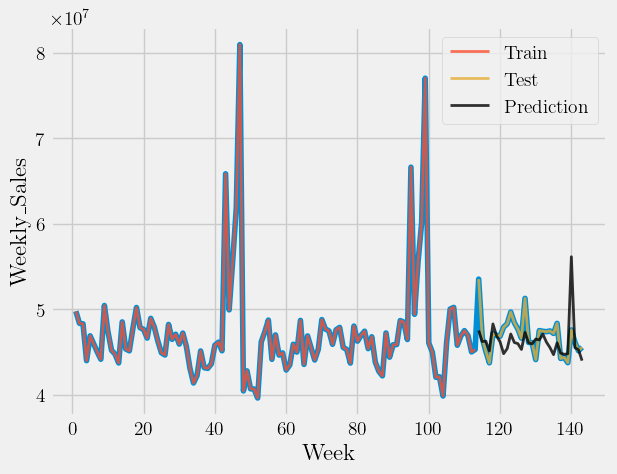

In [357]:
i = 2
X_train = train[i][FEATURES]
X_cv = cv[i][FEATURES]

y_train = train[i][TARGET]
y_cv = cv[i][TARGET]

xg_reg = xg.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=500, objective='reg:squarederror',
                             max_depth=2, learning_rate=0.05)

xg_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_cv, y_cv)], verbose=0)
y_pred = xg_reg.predict(X_cv)

sn.lineplot(df['Weekly_Sales'])
sn.lineplot(y_train, lw=2, alpha=0.8, label='Train')
sn.lineplot(y_cv, lw=2, alpha=0.8, label='Test')
sn.lineplot(x=y_cv.index, y=y_pred, lw=2, alpha=0.8, color='k', label='Prediction')
plt.legend()
plt.show()

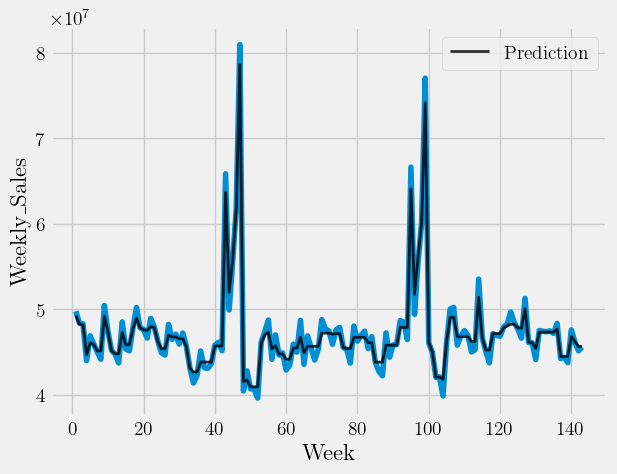

In [370]:
X_train = data_all.index.to_numpy().reshape(-1,1)
y_train = data_all['Weekly_Sales']

xg_reg = xg.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=1000, objective='reg:squarederror',
                             max_depth=2, learning_rate=0.05)

xg_reg.fit(X_train, y_train, verbose=0)
y_pred = xg_reg.predict(X_train)

sn.lineplot(df['Weekly_Sales'])
sn.lineplot(x=X_train.ravel(), y=y_pred, lw=2, alpha=0.8, color='k', label='Prediction')
plt.legend()
plt.show()

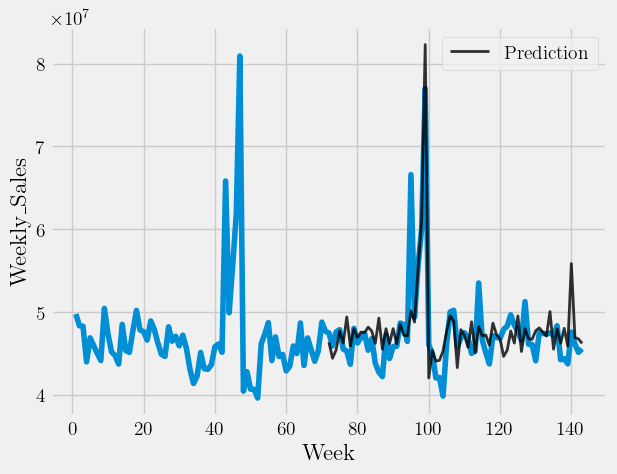

RMSE = 3.1065e+06


In [398]:
m,n = df.shape
X_train = df[FEATURES][:int(m/2)]
y_train = df[TARGET][:int(m/2)]

X_test = df[FEATURES][int(m/2):]
y_test = df[TARGET][int(m/2):]

xg_reg = xg.XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=1000, objective='reg:squarederror',
                             max_depth=2, learning_rate=0.05)

xg_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)
y_pred = xg_reg.predict(X_test)

sn.lineplot(df['Weekly_Sales'])
sn.lineplot(x=X_test['Week'], y=y_pred, lw=2, alpha=0.8, color='k', label='Prediction')
plt.legend()
plt.show()

print('RMSE = %.4e'%np.sqrt(mean_squared_error(y_test, y_pred)))

In [392]:
m,n = df.shape
X_train = df[FEATURES][:int(m/2)]
y_train = df[TARGET][:int(m/2)]

X_test = df[FEATURES][int(m/2):]
y_test = df[TARGET][int(m/2):]

xg_reg = xg.XGBRegressor()


param_grid = {'eta':[0.1,0.3,0.5], 'gamma':[0,1,2], 'max_depth':[2,5,10], 'n_estimators':[300,500,1000],
                 'learning_rate':[0.01,0.1,0.8], 'max_delta_step':[0,1], 'subsample':[0.5,1]}

grid = GridSearchCV(xg_reg, param_grid, cv=3)
grid.fit(X_train, y_train)

xg_best = grid.best_estimator_
print(grid.best_params_)

{'eta': 0.1, 'gamma': 0, 'learning_rate': 0.01, 'max_delta_step': 0, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.5}


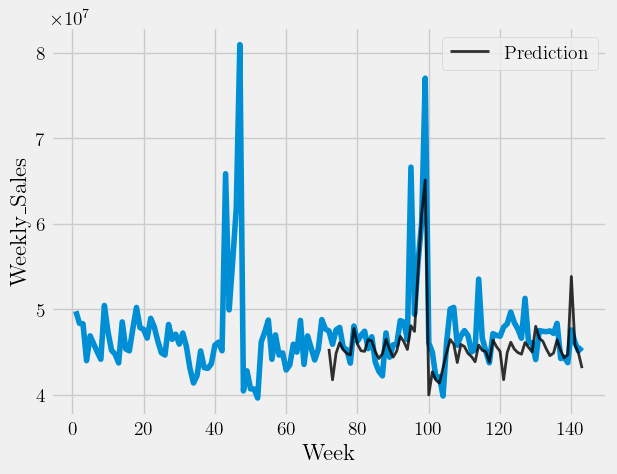

In [393]:
y_pred = xg_best.predict(X_test)

sn.lineplot(df['Weekly_Sales'])
sn.lineplot(x=X_test['Week'], y=y_pred, lw=2, alpha=0.8, color='k', label='Prediction')
plt.legend()
plt.show()

In [397]:
print('RMSE = %.4e'%np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE = 3.5834e+06
